In [40]:
import numpy as np
import pandas as pd
import re

In [41]:
df=pd.read_csv("NYC_obgyn_final.csv", header=None)
df.columns=["Malpractice","Boro","Education","Name","Specialty"]

In [42]:
def split_out_year(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    school=ed[0:s[0]]
    year= ed[s[1]:]
    return year
def split_out_school(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    return ed[0:s[0]]
df['School']=list(map(split_out_school,df.Education))
df['Year']=list(map(split_out_year,df.Education))
df=df.drop("Education",axis=1)

In [43]:
us_states=pd.read_csv("States.csv")
us_states=us_states[us_states.x!='US']
us_states=us_states['x']

df['State'] = df['School'].str.extract('( [A-Z]{2}$)')
df.State=df.State.str.strip()

In [44]:
# Finding country where they went to school
ind=-1
countries=[]
for st in df.State:
    ind+=1
    if st in us_states.values:
        countries.append('USA')
    else:
        try:
            country=re.search(', [A-Z]+$',df.School[ind]).group() #{1}[a-z]
            #print(country[2:])
            countries.append(country[2:])#df['School'].str.extract(', [A-Z]{1}[a-z]+$')
        except Exception as e:
            #print(e)
            countries.append('')
            continue
df['Country']=countries

In [45]:
def find_num_pay(mal):
    # check Judgments and Arbitration Awards
    start,end =re.search('Number of awards:',mal).span()
    try:
        a= int(mal[end+1:end+2])
    except:
        # check Settlements
        start,end_p =re.search('Number of payments:',mal).span()
        a= int(mal[end_p+1:end_p+2])
    return a

In [46]:
ind=0
num_payments=[]
for m in range(len(df)):
    #print(ind)
    if df.Malpractice[ind]=='None reported':
        num_payments.append(0)
    else:
        a=find_num_pay(df.Malpractice[ind])
        num_payments.append(a)
    ind+=1
df['Num_Payments']=num_payments

In [47]:
df['ind_law_suit']=df['Num_Payments']
df['year']=df['Num_Payments']
df['date']=df['Num_Payments']
df['area']=df['Num_Payments']
df['significance']=df['Num_Payments']

def extract_law_suit_info(deets,ind):
    tmp_mal_rows=pd.DataFrame(columns=df.columns)
    for d in range(1,len(deets)):
        suit_info={}
        suit_info['ind_law_suit']=d
        date=re.search('(..-..-....)', deets[d])
        suit_info['date'] = date.group()
        suit_info['year']=date.group()[6:]
        # area might be zip code or County, State
        try:
            area=re.search('\d{5}',deets[d].strip())
            suit_info['area'] = area.group()
            suit_info['significance']= deets[d].strip()[area.span()[1]+1:]
        except:
            try:
                _,end=date.span()
                area_obj=re.search('[A-Za-z]* *[\w]*(, NY)',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
            except:
                _,end=date.span()
                area_obj=re.search('Not Available',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
        tmp_row=pd.DataFrame([df.loc[ind]],columns=df.columns)
        tmp_row['date']=suit_info['date']
        tmp_row['year']=suit_info['year']
        tmp_row['area']=suit_info['area']
        tmp_row['significance']=suit_info['significance']
        tmp_row['ind_law_suit']=suit_info['ind_law_suit']
        tmp_mal_rows=pd.concat([tmp_mal_rows, tmp_row], axis=0)
    return tmp_mal_rows

In [48]:
# Fill in Law Suit info!
# creates empty data frame to fill
mal_rows=pd.DataFrame(columns=df.columns)
for ind in range(len(df)):
    #print(ind)
    mal=df.Malpractice[ind]
    if mal=='None reported':
        continue
    start,end =re.search('High   |   Low\n',mal).span()
    start2,end2=re.search("\n\nThe doctor\'s malpractice history",mal).span()
    deets=mal[end:start2].strip()
    deets=deets.split('\n')
    if re.search('None reported',deets[1]) != None:
        x,y=re.search('\n(..-..-....)',mal).span()
        x2,y2=re.search('\n\nSettlements',mal).span()
        deets=[0,mal[x+1:x2]]
    tmp_mal_rows=extract_law_suit_info(deets,ind)
    mal_rows=pd.concat([mal_rows, tmp_mal_rows], axis=0)
bueno_rows=df[df.Malpractice=="None reported"]
new_df=pd.concat([bueno_rows,mal_rows],axis=0)

# date_rows.year=list(map(lambda x: int(x),date_rows.year))

In [49]:
df['Name'].apply(lambda x: " ".join(x.title() for x in x.split()))
# remove commas
df['Name']=df['Name'].apply(lambda x: " ".join([x.split()[1].title(),x.split()[0][:-1].title()]))

In [113]:
df.to_csv("nysdr_clean.csv")

In [63]:
df_webmd=pd.read_csv("/Users/sophiegeoghan/Desktop/webmd_nyc/webmd_nyc/webmd_all.csv", header=None)
df_webmd.columns=['Name',"Rating"]
df_webmd=df_webmd.drop_duplicates('Name')

df_webmd['Name'] = df_webmd['Name'].apply(lambda x: re.sub('( [A-Z]{1,1}). ', ' ', x))
df_webmd['Name']=df_webmd['Name'].apply(lambda x: re.sub('(, MD)', '', x))

In [110]:
df_hg=pd.read_csv("healthgrades_zips.csv", header=None) #/Users/sophiegeoghan/Desktop/
df_hg.columns=["Rating","Name","N_Reviews"]
df_hg=df_hg.drop_duplicates("Name")
df_hg['Name'] = df_hg['Name'].apply(lambda x: re.sub('Dr. ', ' ', x))
df_hg['Name']=df_hg['Name'].apply(lambda x: re.sub('(, MD)', '', x))

In [112]:
df_merge = pd.merge(df, df_hg, on='Name')
# df_merge.loc[(int(df_merge['Rating'])!=0)]
print(df.dtypes)
df_hg.dtypes
df_merge

Malpractice     object
Boro            object
Name            object
Specialty       object
School          object
Year            object
State           object
Country         object
Num_Payments     int64
ind_law_suit     int64
year             int64
date             int64
area             int64
significance     int64
dtype: object


,Malpractice,Boro,Name,Specialty,School,Year,State,Country,Num_Payments,ind_law_suit,year,date,area,significance,Rating,N_Reviews


In [101]:
df.sample(10)

,Malpractice,Boro,Name,Specialty,School,Year,State,Country,Num_Payments,ind_law_suit,year,date,area,significance
975,None reported,Manhattan (Borough),Shahnoz Rustamova,Obstetrics and Gynecology,"SAMARKANDSKIJ MEDICAL INSTITUTE, SAMARKAND, UZ...",1995,NaN,UZBEKISTAN,0,0,0,0,0,0
1047,None reported,Manhattan (Borough),Miklos Toth,Obstetrics and Gynecology,"SEMMELWEIS ORVOSTUDOMANYI EGYETEM, BUDAPEST, H...",1965,NaN,HUNGARY,0,0,0,0,0,0
120,Malpractice\nLast Updated 11-10-2011\nTO TOP\n...,Brooklyn,Yi-Chun Lee,Obstetrics and Gynecology/Gynecologic Oncology,"TEMPLE UNIVERSITY SCHOOL OF MEDICINE, PHILADEL...",1993,PA,USA,2,2,2,2,2,2
516,None reported,Queens,Rajeevi Madankumar,Obstetrics and Gynecology,"MADURAI MEDICAL COLLEGE, MADURAI UNIVERSITY, M...",1989,NaN,INDIA,0,0,0,0,0,0
61,Malpractice\nLast Updated 12-30-2014\nTO TOP\n...,Brooklyn,Eugene Ellis,Obstetrics and Gynecology,"NEW YORK MEDICAL COLLEGE, VALHALLA NY",1977,NY,USA,4,4,4,4,4,4
934,Malpractice\nLast Updated 04-17-2018\nTO TOP\n...,Manhattan (Borough),Renuka Paka,Obstetrics and Gynecology,"GUNTUR MEDICAL COLLEGE, NTR UNIVERSITY OF HEAL...",1976,NaN,INDIA,2,2,2,2,2,2
263,None reported,Bronx,Siobhan Dolan,Obstetrics and Gynecology,"HARVARD MEDICAL SCHOOL, BOSTON MA",1993,MA,USA,0,0,0,0,0,0
591,None reported,Queens,Michael Wenof,Obstetrics and Gynecology/Reproductive Endocri...,JEFFERSON MEDICAL COLLEGE THOMAS JEFFERSON UNI...,1974,PA,USA,0,0,0,0,0,0
826,None reported,Manhattan (Borough),Tamara Kolev,Obstetrics and Gynecology,"FL STATE UNIV COLL OF MED, TALLAHASSEE FL",2007,FL,USA,0,0,0,0,0,0
781,None reported,Manhattan (Borough),Marcia Harris,Gynecology Only,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,1975,NaN,,0,0,0,0,0,0


In [102]:
df_hg.sample(10)

,Rating,Name,N_Reviews
34,Rated 5 out of 5 stars,Babak Litkouhi,20 reviews
53,Rated 5 out of 5 stars,Lawrence VanHorn Jr,16 reviews
15,Rated 4.5 out of 5 stars,Annette Baggott,10 reviews
26,Rated 4.5 out of 5 stars,Tracy Scheller,38 reviews
54,Rated 4.5 out of 5 stars,Sharyn Lewin,37 reviews
3,Rated 4.5 out of 5 stars,Manuel Sy,2 reviews
36,Rated 2.5 out of 5 stars,Amy Siegel,13 reviews
62,Rated 4.5 out of 5 stars,Alan Garely,69 reviews
35,Rated 4.5 out of 5 stars,Joseph Cipriano,8 reviews
57,Rated 4.5 out of 5 stars,Balwant Chhatwal,8 reviews


In [74]:
df_merge['Rating']=df_merge['Rating'].apply(lambda x: int(x))

In [75]:
df_merge.dtypes

Malpractice     object
Boro            object
Name            object
Specialty       object
School          object
Year            object
State           object
Country         object
Num_Payments     int64
ind_law_suit     int64
year             int64
date             int64
area             int64
significance     int64
Rating           int64
dtype: object

In [76]:
%matplotlib inline

In [77]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

Text(0,0.5,'Rating')

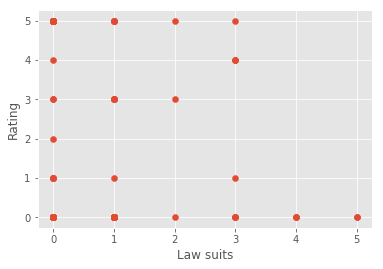

In [88]:
plt.scatter(df_merge['Num_Payments'], df_merge['Rating'])
plt.xlabel('Law suits')
plt.ylabel('Rating')

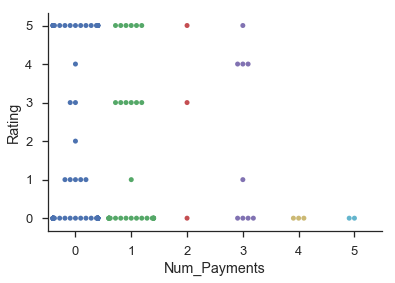

In [90]:
import seaborn as sns

sns.set(style='ticks', context='talk')
#snsDF = sns.load_dataset('df_merge')

sns.swarmplot('Num_Payments', 'Rating', data=df_merge)
sns.despine()

In [91]:
df_merge_nonZero= df_merge.loc[df_merge['Rating'] > 0]

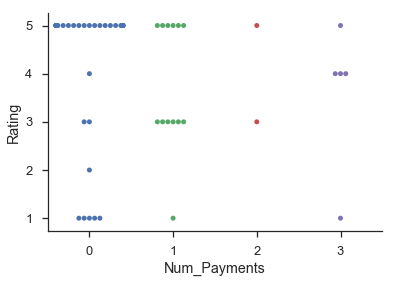

In [92]:
sns.set(style='ticks', context='talk')
#snsDF = sns.load_dataset('df_merge')

sns.swarmplot('Num_Payments', 'Rating', data=df_merge_nonZero)
sns.despine()

In [109]:
sns.set(style='ticks', context='talk')
sns.stripplot('Num_Payments', 'Rating', data=df_merge, jitter=0.2)
sns.despine()

ValueError: min() arg is an empty sequence